<a href="https://colab.research.google.com/github/sicario001/COL780-Project/blob/main/run_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qgRXM0ZiX5_L0V-e1cr_clc2uHDFVcyz' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qgRXM0ZiX5_L0V-e1cr_clc2uHDFVcyz" -O starter_code.zip && rm -rf /tmp/cookies.txt

--2021-11-30 09:19:26--  https://docs.google.com/uc?export=download&confirm=&id=1qgRXM0ZiX5_L0V-e1cr_clc2uHDFVcyz
Resolving docs.google.com (docs.google.com)... 173.194.216.113, 173.194.216.102, 173.194.216.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.216.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-5k-docs.googleusercontent.com/docs/securesc/8k5uah0u1venolq6j1sv8qd6pd8du9vc/jdp0mld31g7i60ts8hqi6n4731sqlfn0/1638263925000/08196725501150479867/10292222811025604094Z/1qgRXM0ZiX5_L0V-e1cr_clc2uHDFVcyz?e=download [following]
--2021-11-30 09:19:34--  https://doc-0c-5k-docs.googleusercontent.com/docs/securesc/8k5uah0u1venolq6j1sv8qd6pd8du9vc/jdp0mld31g7i60ts8hqi6n4731sqlfn0/1638263925000/08196725501150479867/10292222811025604094Z/1qgRXM0ZiX5_L0V-e1cr_clc2uHDFVcyz?e=download
Resolving doc-0c-5k-docs.googleusercontent.com (doc-0c-5k-docs.googleusercontent.com)... 173.194.215.132, 2607:f8b0:400c:c0c::84
Connectin

In [106]:
!unzip -o starter_code

Archive:  starter_code.zip
2f4309617046ecaf0bd5d1862c42ed370a17f46c
  inflating: reid-col780-master/README.md  
  inflating: reid-col780-master/data/train/001/01_1.png  
  inflating: reid-col780-master/data/train/001/01_2.png  
  inflating: reid-col780-master/data/train/001/01_3.png  
  inflating: reid-col780-master/data/train/001/01_4.png  
  inflating: reid-col780-master/data/train/001/01_5.png  
  inflating: reid-col780-master/data/train/001/01_6.png  
  inflating: reid-col780-master/data/train/001/01_7.png  
  inflating: reid-col780-master/data/train/001/01_8.png  
  inflating: reid-col780-master/data/train/001/02_1.png  
  inflating: reid-col780-master/data/train/001/02_2.png  
  inflating: reid-col780-master/data/train/001/02_3.png  
  inflating: reid-col780-master/data/train/001/02_4.png  
  inflating: reid-col780-master/data/train/001/02_5.png  
  inflating: reid-col780-master/data/train/001/02_6.png  
  inflating: reid-col780-master/data/train/001/02_7.png  
  inflating: reid-

In [107]:
import os
import sys
starter_path = os.path.abspath(os.getcwd())+'/reid-col780-master'
sys.path.insert(0, starter_path)

In [108]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd

In [109]:
from torch.nn import Conv2d,Linear, Module, Sequential,BatchNorm2d,MaxPool2d
import torch.nn.functional as F

In [110]:
class ResidualBlock(Module):
  def __init__(self,in_channels,increase_dims=False,is_first=False):
        super(ResidualBlock, self).__init__()
        self.increase_dims = increase_dims
        self.is_first = is_first
        self.bn_0 = None
        self.conv_up = None
        out_channels = in_channels
        stride = 1
        if increase_dims:
          out_channels*=2
          stride*=2
          # self.conv_up = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=1,stride=2,padding="same")
          self.conv_up = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=1,stride=2)
        if not is_first:
          self.bn_0 = nn.Sequential(
              nn.BatchNorm2d(in_channels),
              nn.ELU()
          )
        if increase_dims:
          self.conv_1 = nn.Sequential(
              # nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=stride,padding="same"),
              nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=stride),
              nn.BatchNorm2d(out_channels),
              nn.ELU(),
              nn.Dropout(p=0.4)
          )
        else:
          self.conv_1 = nn.Sequential(
              nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=stride,padding="same"),
              # nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=stride),
              nn.BatchNorm2d(out_channels),
              nn.ELU(),
              nn.Dropout(p=0.4)
          )
        self.conv_2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,stride=1,padding="same")
  def forward(self,x):
      if self.bn_0:
        y = self.bn_0(x)
      else:
        y = x
      residual = x
      if self.increase_dims:
        y = F.pad(y, (0, 1, 0, 1))
      out = self.conv_1(y)
      out = self.conv_2(out)
      if self.conv_up:
        residual = self.conv_up(residual)
      return out+residual

In [111]:
class BigNet(Module):   
    def __init__(self):
        super(BigNet, self).__init__()
        self.conv_1 = nn.Sequential(
          nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding="same"),
          nn.BatchNorm2d(32),
          nn.ELU()
        )
        self.conv_2 = nn.Sequential(
          nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding="same"),
          nn.BatchNorm2d(32),
          nn.ELU()
        )
        # self.pool_3 = nn.MaxPool2d(kernel_size=3,stride=2,padding="same")
        self.pool_3 = nn.MaxPool2d(kernel_size=3,stride=2)
        
        self.residual_4 = ResidualBlock(in_channels=32,is_first=True)
        self.residual_5 = ResidualBlock(in_channels=32)
        self.residual_6 = ResidualBlock(in_channels=32,increase_dims=True)
        self.residual_7 = ResidualBlock(in_channels=64)
        self.residual_8 = ResidualBlock(in_channels=64,increase_dims=True)
        self.residual_9 = ResidualBlock(in_channels=128)

        

    # Defining the forward pass    
    def forward(self, x):
        out = self.conv_1(x)
        out = self.conv_2(out)
        out = F.pad(out, (0, 1, 0, 1))
        out = self.pool_3(out)
        out = self.residual_4(out)
        out = self.residual_5(out)
        out = self.residual_6(out)
        out = self.residual_7(out)
        out = self.residual_8(out)
        out = self.residual_9(out)
        # out = self.dense_10(out)
        # out = nn.functional.normalize(out,p=2,dim=1)
        # out = self.cosine_layer(out)
        return out

In [112]:
class SliceNet(Module):
  def __init__(self, numClasses = 2, inference = False):
    super(SliceNet, self).__init__()
    self.inference = inference
    self.numClasses = numClasses
    self.bignet = BigNet()
    self.dense_10 = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.4),
        nn.Linear(in_features=128*4*6,out_features=32),
        nn.BatchNorm1d(32),
        nn.ELU()
    )
    self.cosine_layer = nn.utils.weight_norm(nn.Linear(in_features=128,out_features=numClasses,bias=False))

  def forward(self, x):
    out = self.bignet(x)
    # print(out.shape)
    x_slices = torch.split(out,split_size_or_sections=4,dim=2)
    # print(x_slices[0].shape)
    out_slices = []
    for x_slice in x_slices:
      out = self.dense_10(x_slice)
      out_slices.append(out)
    # print(out_slices[0].shape)
    out = torch.cat(out_slices,dim=1)
    out = nn.functional.normalize(out,p=2,dim=1)
    # print(out.shape)
    # assert False
    if (not self.inference):
      out = self.cosine_layer(out)
    return out

In [113]:
!apt install libomp-dev
!pip install faiss
!pip install faiss-gpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [114]:
# Evaluation 
# Acknowledgement: the code is based on Siddhant Kapil's repo on LA-Transformer

from __future__ import print_function

import os, sys
import faiss
import numpy as np

from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from model import ReidModel, DummyModel
from utils import get_id
from metrics import rank1, rank5, calc_ap



# ### Set feature volume sizes (height, width, depth) 
# TODO: update with your model's feature length

batch_size = 1
H, W, D = 1, 1, 128 # for dummymodel we have feature volume 7x7x2048

# ### Load Model

# TODO: Uncomment the following lines to load the Implemented and trained Model

save_path = "final_model_slice_alt_100.pth"
model = SliceNet(numClasses = 62, inference=True)
model.load_state_dict(torch.load(save_path,map_location=torch.device('cpu')), strict=False)
model.eval()

# TODO: Comment out the dummy model
# model = DummyModel(batch_size, H, W, D)

# ### Data Loader for query and gallery

# TODO: For demo, we have resized to 224x224 during data augmentation
# You are free to use augmentations of your own choice
transform_query_list = [
        transforms.Resize((128,48), interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
transform_gallery_list = [
        transforms.Resize(size=(128,48), interpolation=3), #Image.BICUBIC
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]

data_transforms = {
        'query': transforms.Compose( transform_query_list ),
        'gallery': transforms.Compose(transform_gallery_list),
    }


image_datasets = {}
data_dir = starter_path+"/data/val"

image_datasets['query'] = datasets.ImageFolder(os.path.join(data_dir, 'query'),
                                          data_transforms['query'])
image_datasets['gallery'] = datasets.ImageFolder(os.path.join(data_dir, 'gallery'),
                                          data_transforms['gallery'])
query_loader = DataLoader(dataset = image_datasets['query'], batch_size=batch_size, shuffle=False )
gallery_loader = DataLoader(dataset = image_datasets['gallery'], batch_size=batch_size, shuffle=False)

class_names = image_datasets['query'].classes


# ###  Extract Features

def extract_feature(dataloaders):
    
    features =  torch.FloatTensor()
    count = 0
    idx = 0
    for data in tqdm(dataloaders):
        img, label = data
        # print(label)
        # Uncomment if using GPU for inference
        #img, label = img.cuda(), label.cuda()

        output = model(img) # (B, D, H, W) --> B: batch size, HxWxD: feature volume size
        n, c, h, w = img.size()
        
        count += n
        features = torch.cat((features, output.detach().cpu()), 0)
        idx += 1
    return features

# Extract Query Features

query_feature= extract_feature(query_loader)

# Extract Gallery Features

gallery_feature = extract_feature(gallery_loader)

# Retrieve labels

gallery_path = image_datasets['gallery'].imgs
query_path = image_datasets['query'].imgs

gallery_cam,gallery_label = get_id(gallery_path)
query_cam,query_label = get_id(query_path)


# ## Concat Averaged GELTs
concatenated_query_vectors = []
for query in tqdm(query_feature):
    fnorm = torch.norm(query, p=2, dim=0, keepdim=True)#*np.sqrt(H*W)
    query_norm = query.div(fnorm.expand_as(query))
    concatenated_query_vectors.append(query_norm.view((-1)))

concatenated_gallery_vectors = []
for gallery in tqdm(gallery_feature):
    fnorm = torch.norm(gallery, p=2, dim=0, keepdim=True)#*np.sqrt(H*W)
    gallery_norm = gallery.div(fnorm.expand_as(gallery))
    concatenated_gallery_vectors.append(gallery_norm.view((-1)))
  

# ## Calculate Similarity using FAISS

index = faiss.IndexIDMap(faiss.IndexFlatIP(H*W*D))
# combine label and index into id
ids = np.array(gallery_label)*1000+np.arange(len(gallery_label))
index.add_with_ids(np.array([t.numpy() for t in concatenated_gallery_vectors]),ids)

def search(query: str, k=1):
    encoded_query = query.unsqueeze(dim=0).numpy()
    top_k = index.search(encoded_query, k)
    return top_k


# ### Evaluate 

rank1_score = 0
rank5_score = 0
ap = 0
count = 0
result_indexes_all = []

for query, label in zip(concatenated_query_vectors, query_label):
    count += 1
    label = label
    output = search(query, k=10)
    # get indices
    result_indexes_all.append((len(result_indexes_all),(output[1]%1000).flatten()))
    # get labels
    output = (output[0],output[1]//1000)
    rank1_score += rank1(label, output) 
    rank5_score += rank5(label, output) 
    print("Correct: {}, Total: {}, Incorrect: {}".format(rank1_score, count, count-rank1_score), end="\r")
    ap += calc_ap(label, output)

print("Rank1: %.3f, Rank5: %.3f, mAP: %.3f"%(rank1_score/len(query_feature), 
                                             rank5_score/len(query_feature), 
                                             ap/len(query_feature)))

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Rank1: 0.929, Rank5: 1.000, mAP: 0.788


In [115]:
inv_normalize_gallery = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)
inv_normalize_query = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [116]:
def get_gallery_image(i):
  return inv_normalize_gallery(image_datasets['gallery'].__getitem__(i)[0]).permute(1,2,0)
def get_query_image(i):
  return inv_normalize_query(image_datasets['query'].__getitem__(i)[0]).permute(1,2,0)

In [117]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
def showImagesHorizontally(list_of_images):
    fig = figure(figsize=(16,60))
    number_of_files = len(list_of_images)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = list_of_images[i]
        image/=image.max()
        imshow(image)
        axis('off')

1


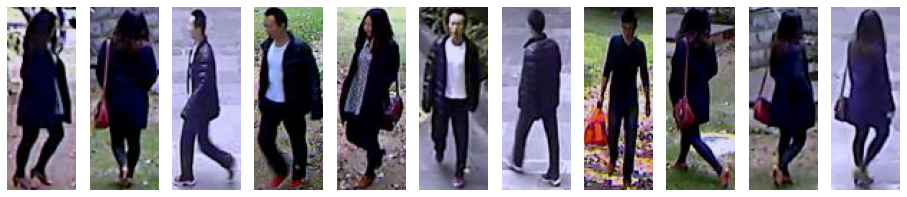

2


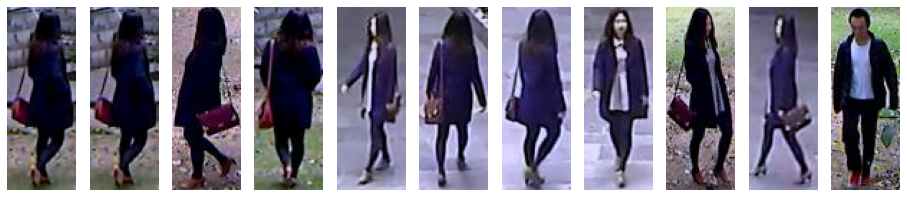

3


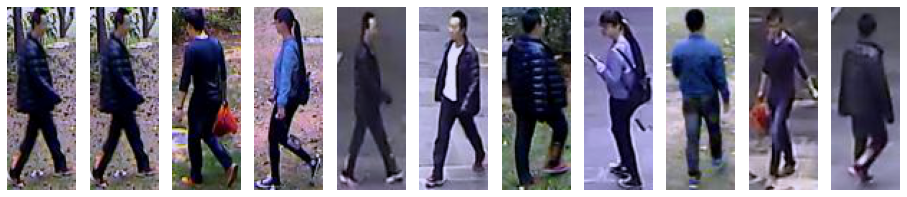

4


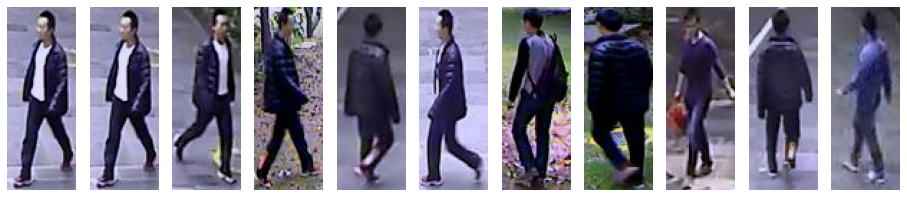

5


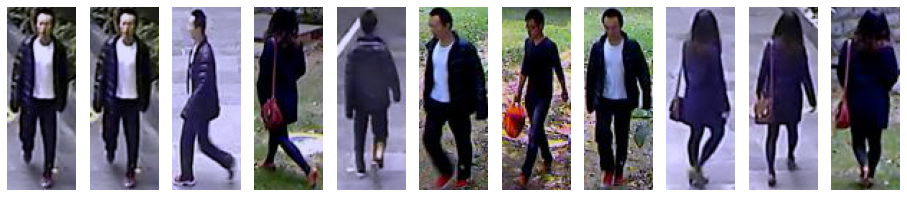

6


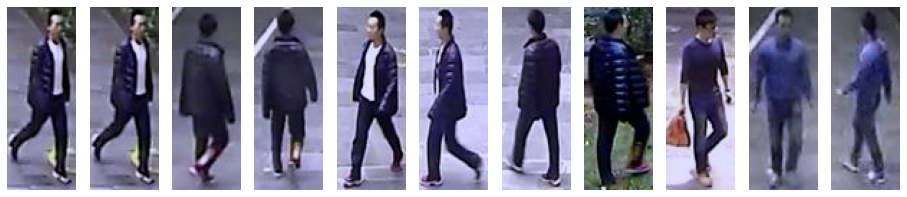

7


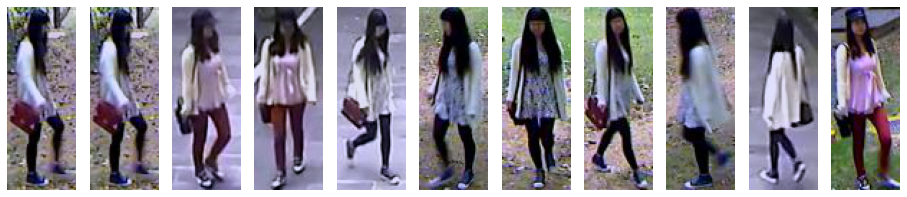

8


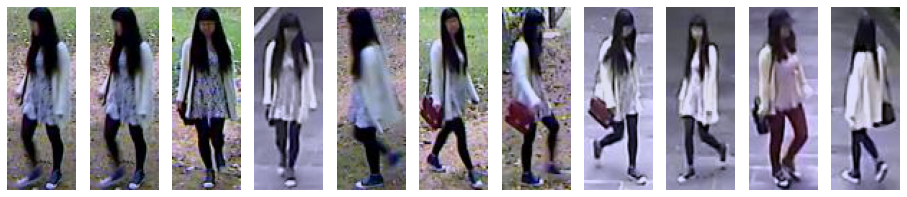

9


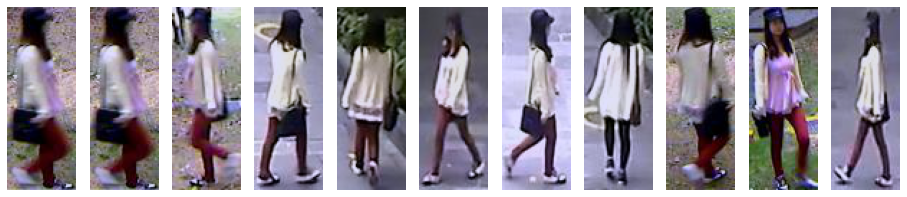

10


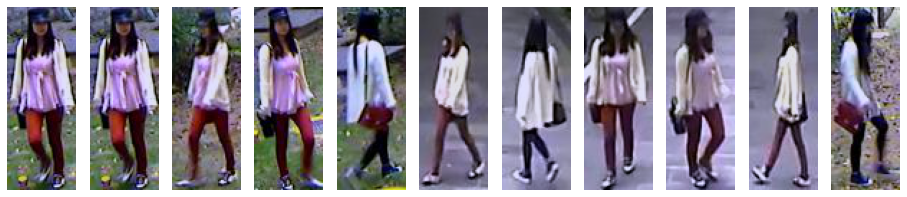

11


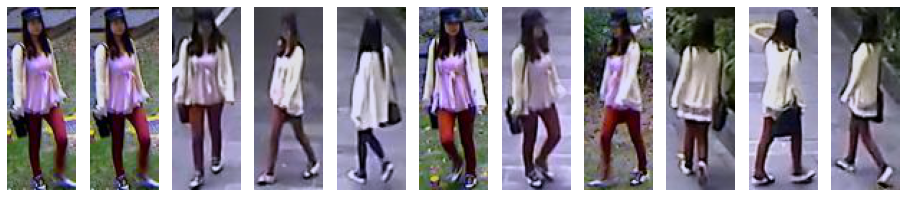

12


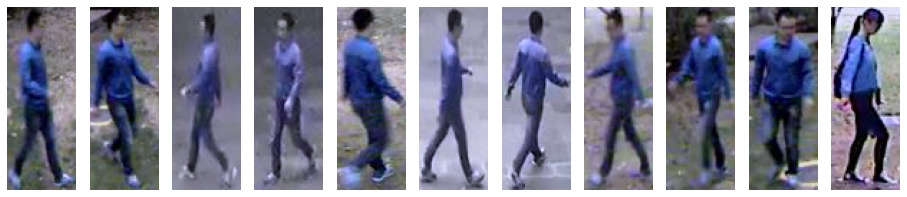

13


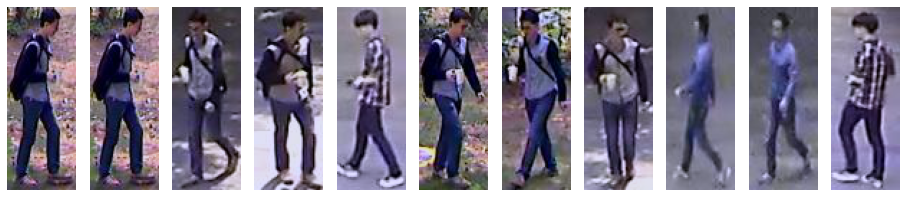

14


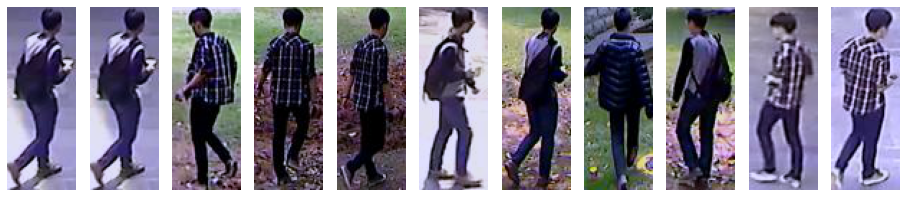

15


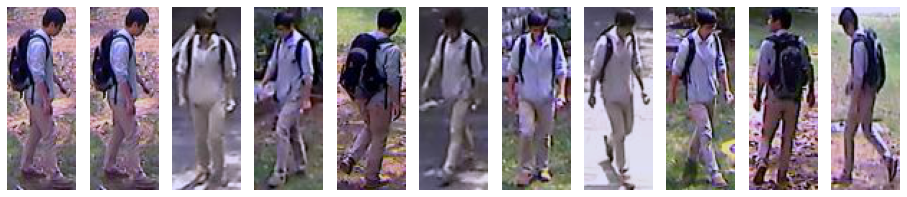

16


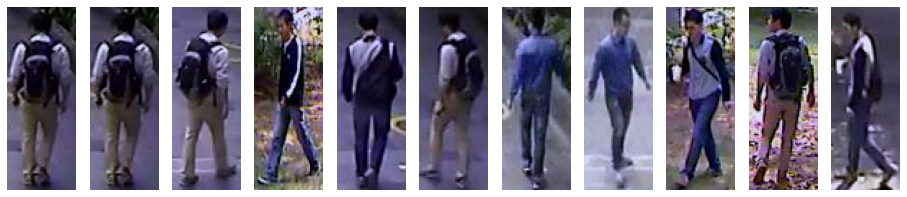

17


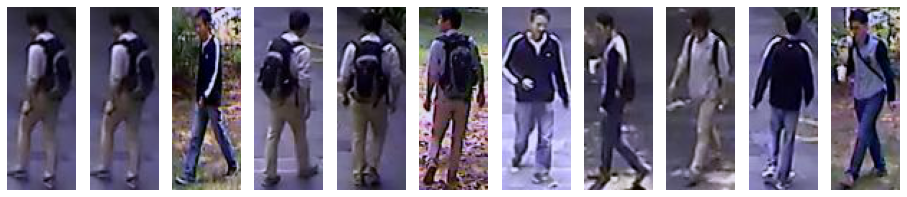

18


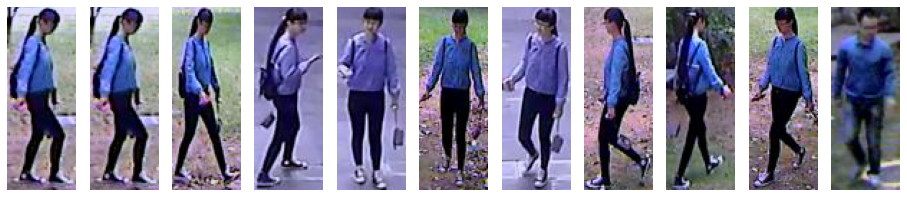

19


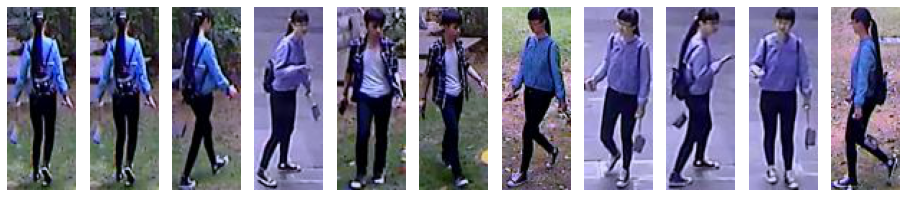

20


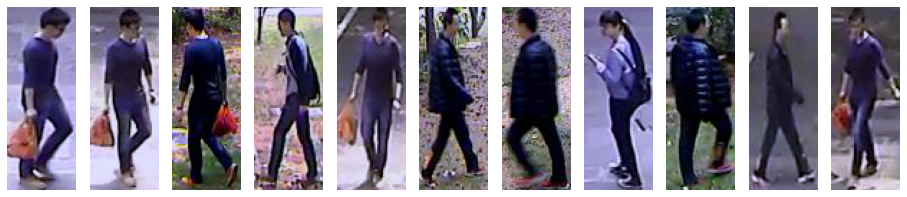

21


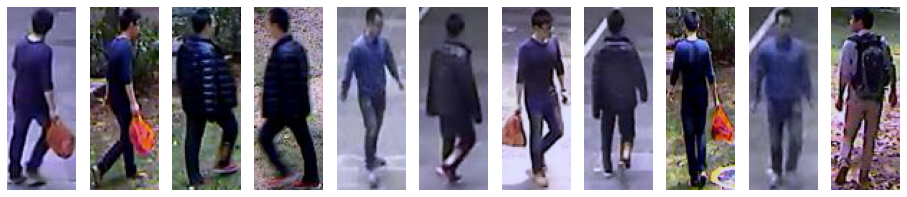

22


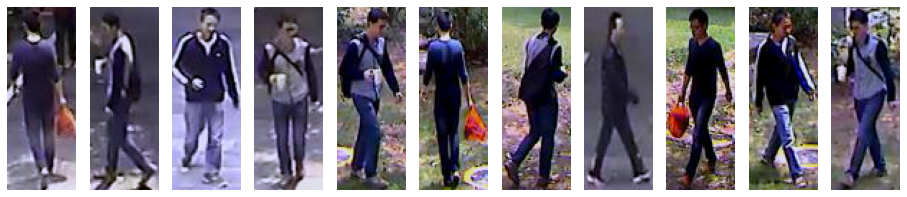

23


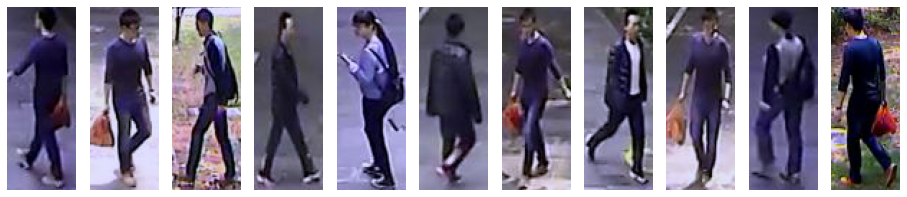

24


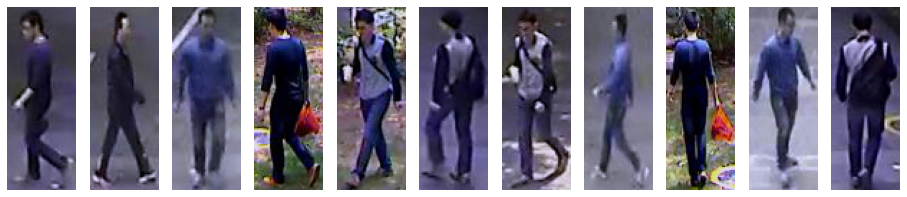

25


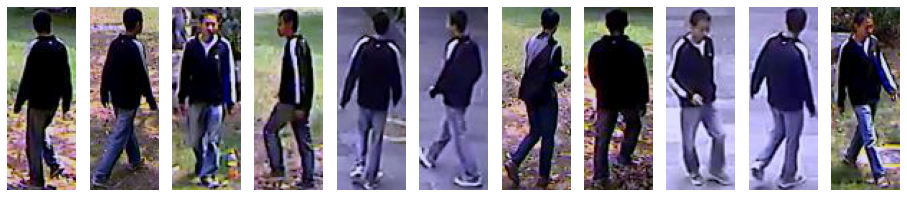

26


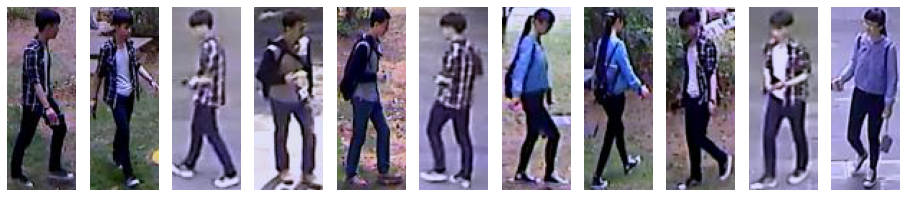

27


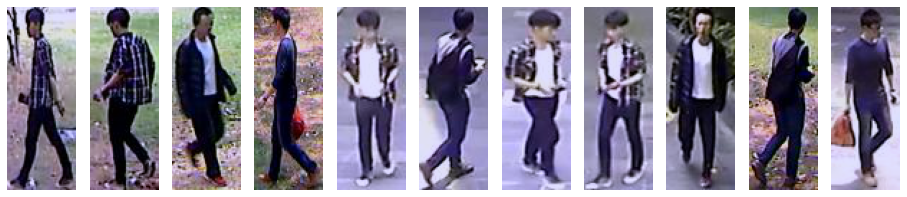

28


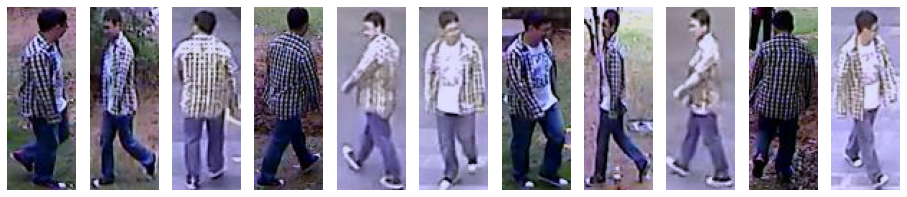

In [118]:
for i,p in enumerate(result_indexes_all):
  q,r=p
  print(i+1)
  showImagesHorizontally([get_query_image(q)]+list(map(get_gallery_image,r)))
  plt.show()